In [13]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

import tensorflow as tf
import numpy as np 
import matplotlib 
import os
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, BatchNormalization , ReLU, LeakyReLU, Dropout,Reshape
from keras.optimizers import Adam
import cv2

import matplotlib.pyplot as plt
from tqdm import tqdm


In [0]:
def discriminator():
	model = Sequential()
	model.add(Conv2D(8, (3,3) , strides= (2,2), padding= 'same',input_shape = (256,256,3)))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))

#128*128*8
	
	model.add(Conv2D(16, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization( momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#64*64*16

	model.add(Conv2D(32, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#32*32*32

	model.add(Conv2D(64, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#16*16*64

	model.add(Conv2D(128, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#8*8*128
	model.add(Conv2D(256, (3,3) , strides= (2,2), padding= 'same'))
	model.add(BatchNormalization(momentum= 0.7))
	model.add(LeakyReLU(0.2))
	model.add(Dropout(0.3))
#4*4*256
	model.add(Flatten())
	model.add(Dense(128))
	model.add(LeakyReLU(0.2))


	model.add(Dense(1,activation ='sigmoid'))
	optimus = Adam(learning_rate= 0.0002 ,beta_1=0.5)
	model.compile(optimizer= optimus, loss = 'binary_crossentropy',metrics=['accuracy'])

	return model



In [0]:
def generator(latent_dim):
	model = Sequential()
	model.add(Dense((4096),input_dim = latent_dim))
	model.add(Reshape((1,1,4096)))

	model.add(Conv2DTranspose(512, (4,4) , strides=(2,2), padding='same'))
	model.add(ReLU())
#2*2*512
	model.add(Conv2DTranspose(256,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#4*4*256
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#8*8*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#16*16*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#32*32*128
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#64*64*128	
	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))
#128*128*128

	model.add(Conv2DTranspose(128,(4,4),strides= 2, padding = 'same'))
	model.add(BatchNormalization(momentum=0.7))
	model.add(ReLU())
	model.add(Dropout(0.3))

#256*256*4
	model.add(Conv2D(3,(3,3),activation= 'tanh',padding = 'same'))
	optimus = Adam(learning_rate=0.0002,beta_1=0.5)

	model.compile(optimizer=optimus , loss = 'binary_crossentropy')

	return model



In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def gan(g_model,d_model):

	d_model.trainable = False
	model =Sequential()
	model.add(g_model)
	model.add(d_model)
	optimus = Adam(learning_rate=0.0002,beta_1=0.5)
	model.compile(optimizer=optimus,loss='binary_crossentropy')
	return model


In [0]:
def load_real_data(xsam):
    
    x= np.array(xsam).reshape(-1,256,256,3)
    x = (x-127.5)/127.5
    print(x.shape)
    return x

In [0]:
def generate_real_samples(dataset , n_samples):

	for i in range (n_samples):
		index = np.random.randint(0 , dataset.shape[0] , n_samples)

		image = dataset[index]
		y = np.ones((n_samples,1))

		return image,y

In [0]:

def generate_latent_sample(laten_dim,n_samples):
	
	x = np.random.randn(laten_dim*n_samples)
	x = x.reshape(n_samples,laten_dim)

	return x

In [0]:
def generate_fake_samples(g_model, latent_dim,n_samples):
	
	x = generate_latent_sample(latent_dim,n_samples)
	x = g_model.predict(x)
	y = np.zeros((n_samples,1))

	return x,y

In [0]:
def save_plot(examples ,epoch , n = 7):
	examples = (examples+1) / 2.0

	for i in range(n*n):
		pyplot.subplot(n,n,1+i)
		pyplot.axis('off')
		pyplot.imshow(examples[i])
	filename = 'generated_plot_e%0.3d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


In [0]:
def summarize_performance(epoch,g_model,d_model,dataset,latent_dim,n_samples = 150):

	x_real ,y_real = generate_real_samples(dataset,n_samples)
	_,acc_real = d_model.evaluate(x_real,y_real)

	x_fake,y_fake = generate_fake_samples(g_model,latent_dim,n_samples)
	_,acc_fake = d_model.evaluate(x_fake,y_fake)

	print(('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)))
	save_plot(x_fake,epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)



In [0]:
def train(g_model,d_model,gan_model, dataset ,latent_dim, n_epoch = 150, n_batch = 32):
	batch_per_epoch = int(dataset.shape[0]/n_batch)
	batch = int(n_batch/2)

	for i in range(n_epoch):
		for j in range (batch_per_epoch):

			x_real,y_real = generate_real_samples(dataset,batch)

			d_model_loss1,_ = d_model.train_on_batch(x_real,y_real)

			x_fake ,y_fake = generate_fake_samples(g_model,latent_dim,batch)

			d_model_loss2,_ =d_model.train_on_batch(x_fake,y_fake)

			x_gan = generate_latent_sample(latent_dim, n_batch)
			y_gan = np.ones((n_batch,1))

			g_model_loss = gan_model.train_on_batch(x_gan,y_gan)

			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f'% 
                  (i+1, j+1, batch_per_epoch, d_model_loss1, d_model_loss2, g_model_loss))
		if (i+1) % 10 ==0 :
			summarize_performance(i,g_model,d_model,dataset,latent_dim)


In [0]:
xsam = []
CATEGORIES = [""]
training_data = []
IMG_SIZE = (256)

data_dir = "/content/drive/My Drive/images"

In [28]:
# for category in CATEGORIES:

path = os.path.join(data_dir)  # create path to dogs and cats
# class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

for img in tqdm(os.listdir(path)):
  img_array = cv2.imread(os.path.join(path,img) ,cv2.COLOR_BGR2RGB)  # convert to array
  new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))  # resize to normalize data size
  training_data.append([new_array])  # add this to our training_data


100%|██████████| 150/150 [01:09<00:00,  2.17it/s]


In [29]:
print(len(training_data))

150


In [30]:
np.array(training_data).shape

(150, 1, 256, 256, 3)

In [31]:
for features in training_data:
  
  xsam.append(features)
#  #   return xsam
print(np.array(xsam).shape)
print(np.array(training_data).shape)


(150, 1, 256, 256, 3)
(150, 1, 256, 256, 3)


In [36]:

latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model,d_model)
d_model.summary()
g_model.summary()
print(np.array(training_data).shape)

dataset = load_real_data(xsam)
train(g_model,d_model,gan_model,dataset,latent_dim)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128, 128, 8)       0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 64, 16)       

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/4, d1=0.473, d2=2.693 g=0.366
>1, 2/4, d1=0.328, d2=1.828 g=0.971
>1, 3/4, d1=0.815, d2=0.908 g=1.319
>1, 4/4, d1=1.137, d2=0.825 g=1.022
>2, 1/4, d1=1.242, d2=0.638 g=0.909
>2, 2/4, d1=0.613, d2=1.322 g=0.979
>2, 3/4, d1=0.985, d2=0.636 g=1.117
>2, 4/4, d1=0.882, d2=0.743 g=0.939
>3, 1/4, d1=0.874, d2=0.966 g=1.087
>3, 2/4, d1=0.800, d2=0.701 g=1.210
>3, 3/4, d1=0.906, d2=0.868 g=0.936
>3, 4/4, d1=0.810, d2=0.761 g=1.055
>4, 1/4, d1=0.627, d2=0.518 g=1.049
>4, 2/4, d1=0.971, d2=0.622 g=0.873
>4, 3/4, d1=0.781, d2=0.734 g=0.907
>4, 4/4, d1=0.777, d2=0.903 g=0.853
>5, 1/4, d1=0.861, d2=1.128 g=1.131
>5, 2/4, d1=0.765, d2=0.808 g=1.186
>5, 3/4, d1=0.901, d2=0.632 g=1.262
>5, 4/4, d1=0.581, d2=0.677 g=1.403
>6, 1/4, d1=0.798, d2=0.663 g=1.151
>6, 2/4, d1=0.616, d2=0.685 g=1.221
>6, 3/4, d1=0.683, d2=0.404 g=1.103
>6, 4/4, d1=0.519, d2=0.422 g=1.195
>7, 1/4, d1=0.391, d2=0.368 g=0.762
>7, 2/4, d1=0.403, d2=0.333 g=0.831
>7, 3/4, d1=0.532, d2=0.595 g=0.855
>7, 4/4, d1=0.526, d2=0.428 

Generated Image


<function matplotlib.pyplot.show>

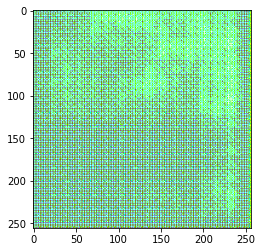

In [39]:
from keras.models import load_model

model = load_model('generator_model_150.h5')
vector = np.asarray([[10.75 for _ in range(100)]])

x= model.predict(vector)
x = (x+1)/2
print("Generated Image")
pyplot.imshow(x[0,:,:])
pyplot.show